In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import timeit
import math
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, validation_curve, GridSearchCV, cross_validate, learning_curve, KFold 
from sklearn import preprocessing
from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn.metrics import mean_squared_error, accuracy_score,precision_score,recall_score,f1_score,confusion_matrix,roc_auc_score, homogeneity_score, plot_confusion_matrix, plot_roc_curve
from sklearn.metrics.pairwise import pairwise_distances, euclidean_distances
from sklearn.neural_network import MLPClassifier
from sklearn import random_projection
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA, FastICA
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans

from scipy.stats import kurtosis
from scipy.spatial.distance import cdist
from collections import Counter,defaultdict
from itertools import product

In [2]:
np.random.seed(2)

# Data Load and preprocess

In [3]:
data_name1 = "./online_shoppers_intention.csv"
data_name2 = "./breast_cancer_wisconsin.csv"

df1 = pd.read_csv(data_name1)
df2 = pd.read_csv(data_name2)

In [4]:
df2.drop(["Unnamed: 32","id"], inplace = True, axis = 1)

/Users/zj88zj/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/zj88zj/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='diagnosis', ylabel='count'>

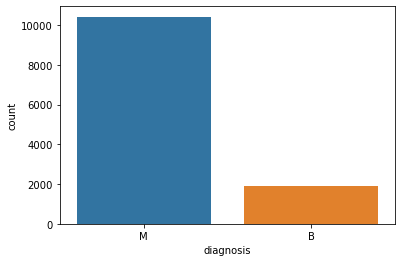

In [5]:
sns.countplot(df1["Revenue"])
sns.countplot(df2["diagnosis"])

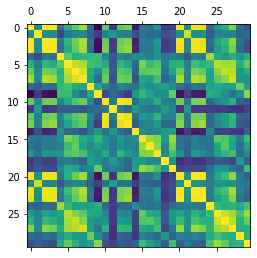

In [6]:
plt.matshow(df2.corr())

In [7]:
corr = df1.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2).to_excel("./df1_corr.xlsx")
corr = df2.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2).to_excel("./df2_corr.xlsx")

/Users/zj88zj/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  
/Users/zj88zj/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  after removing the cwd from sys.path.


In [5]:
target = pd.DataFrame(df1.iloc[:, -1],columns=['Revenue'])
df1 = df1.iloc[:, :-1]
nums,cats = df1.select_dtypes(include=np.number), df1.select_dtypes(exclude=np.number)
nums_t = pd.DataFrame(PowerTransformer().fit_transform(nums),columns=nums.columns)
alls = pd.concat([nums_t,cats],axis=1)
alls['Weekend'].replace({False:0,True:1},inplace =True)
target['Revenue'].replace({False:0,True:1},inplace =True)
alls = pd.get_dummies(alls,drop_first=True)
df1 = pd.concat([alls,target],axis=1)
# df1.columns
# df1.shape
# df1.head()

In [6]:
df2 = df2.rename(columns = {"diagnosis" : "target"})
df2["target"] = [1 if i.strip() == "M" else 0 for i in df2["target"]]
target = pd.DataFrame(df2.iloc[:, 0],columns=["target"])
df2 = df2.iloc[:, 1:]
df2 = pd.DataFrame(PowerTransformer().fit_transform(df2),columns=df2.columns)
# scaler = StandardScaler()
# scaler.fit(df2)
df2 = pd.concat([df2,target],axis=1)
# df2.head()
# df2.shape

C:\Users\jzhang\Anaconda\lib\site-packages\sklearn\preprocessing\_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


In [7]:
X2 = df2.iloc[:, :-1]
y2 = df2.iloc[:, -1]
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2)
# y_test.shape

In [8]:
X1 = df1.iloc[:, :-1]
y1 = df1.iloc[:, -1]
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2)
# y_test.shape

# Clustering

In [34]:
def cluster_choose_km(X, n, name):
    K = list(range(1, n, 1))
    distortions = []
    inertias = []
    for k in K:
        km = KMeans(k, random_state=0).fit(X)
        closest = np.min(cdist(X, km.cluster_centers_, 'euclidean'), axis=1)
        distortions.append(sum(closest) / X.shape[0])
        inertias.append(km.inertia_)

    plt.plot(K, distortions, 'bx-')
    plt.xlabel('Values of K')
    plt.ylabel('Distortion')
    plt.title('Elbow Plot using Distortion')
    plt.savefig('./'+name+'elbow_plot1_kmeans.png')
    plt.show()
    
    plt.plot(K, inertias, 'bx-')
    plt.xlabel('Values of K')
    plt.ylabel('Inertia')
    plt.title('Elbow Plot using Inertia')
    plt.savefig('./'+name+'elbow_plot2_kmeans.png')
    plt.show()

def apply_kmeans(X, y, n, name):
    km = KMeans(n_clusters=n,random_state=2)
    km.fit(X, y)
    labels = km.labels_
    assert (y.shape == labels.shape)
    y_pred = np.empty_like(y)
    for label in set(labels):
        booln = labels == label
        target = Counter(y[booln]).most_common(1)[0][0]
        y_pred[booln] = target

    f1 = f1_score(y, y_pred)
    accuracy = accuracy_score(y, y_pred)
#     precision = precision_score(y, y_pred)
#     recall = recall_score(y, y_pred)
    cm = confusion_matrix(y, y_pred)
    cluster_freq(X, y, km, n, name)


    print("F1 Score:  "+"{:.2f}".format(f1))
    print("Accuracy:  "+"{:.2f}".format(accuracy))
    
    centers = pd.DataFrame(km.cluster_centers_)
    centers.to_csv('./'+name+'_centers_kmeans.csv')

    sns.heatmap(pd.DataFrame(cm),annot=True,fmt='d',cbar=False, cmap="YlGnBu")
    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.savefig('./'+name+'confusion_matrix_kmeans.png')
    plt.show()
    
#     plot_roc_curve(km,X,y)
#     plt.title('Testing')
#     plt.savefig('./'+name+'ROC_kmeans.png')
#     plt.show()

def cluster_freq(X, y, model, n, name):
    m = model.fit(X)
    pred = m.predict(X)
    rang = range(0,n)
    n_pos = []
    n_neg = []
    for l in rang:
        booln = pred == l
        n_pos.append(y[booln].sum())
        n_neg.append(booln.sum() - y[booln].sum())
    c1 = pd.DataFrame({'cluster':rang, 'n':n_pos, 'pos':['+']*len(rang)})
    c2 = pd.DataFrame({'cluster':rang, 'n':n_neg, 'pos':['-']*len(rang)})
    plot_df = pd.concat([c1, c2]).reset_index()

    sns.barplot(data=plot_df, hue='pos', x='cluster', y='n')
    plt.title("label frequency in ecah cluster")
    plt.xlabel('Cluster')
    plt.ylabel('Frequency')
    plt.savefig('./'+name+'freq_plot.png')
    plt.show()
    plt.close()

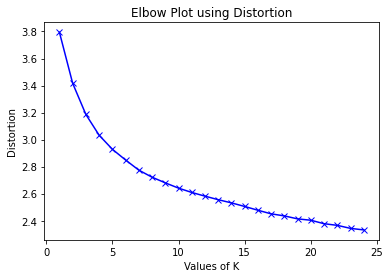

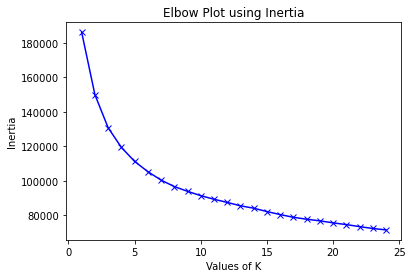

In [40]:
cluster_choose_km(X1, 25, "shoppers")

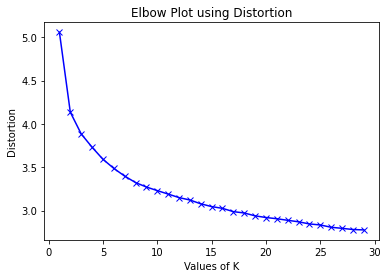

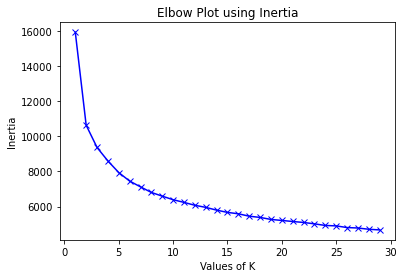

In [14]:
cluster_choose_km(X2, 30, "cancer")

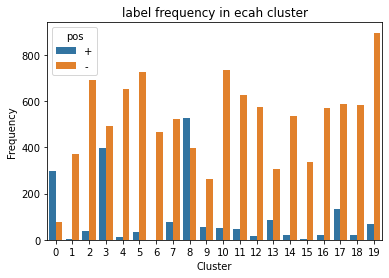

F1 Score:  0.51
Accuracy:  0.87


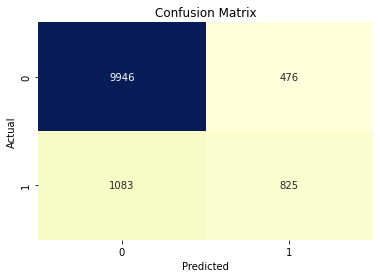

In [43]:
apply_kmeans(X1, y1, 20, "shoppers")

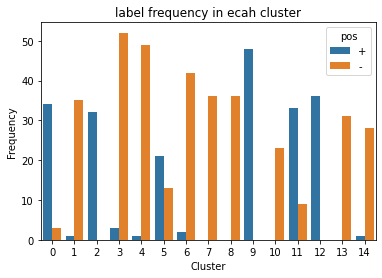

F1 Score:  0.93
Accuracy:  0.94


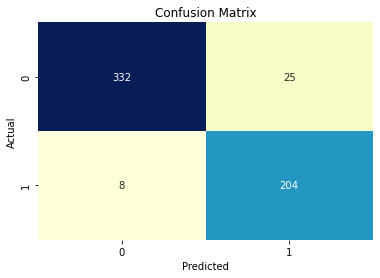

In [44]:
apply_kmeans(X2, y2, 15, "cancer")

In [35]:
def cluster_choose_em(X, n, name):
    K = list(range(1, n, 1))
    distortions = []
    inertias = []
    for k in K:
        em = GaussianMixture(n_components=k, random_state=2).fit(X)
        closest = np.min(cdist(X, em.means_, 'euclidean'), axis=1)
        distortions.append(sum(closest) / X.shape[0])

    plt.plot(K, distortions, 'bx-')
    plt.xlabel('Values of K')
    plt.ylabel('Distortion')
    plt.title('Elbow Plot using Distortion')
    plt.savefig('./'+name+'elbow_plot1_EM.png')
    plt.show()
    
    
def apply_EM(X, y, n, name):
    em = GaussianMixture(n_components=n, random_state=2)
    em.fit(X, y)
    labels = em.predict(X)
    assert (y.shape == labels.shape)
    y_pred = np.empty_like(y)
    for label in set(labels):
        booln = labels == label
        target = Counter(y[booln]).most_common(1)[0][0]
        y_pred[booln] = target

    f1 = f1_score(y, y_pred)
    accuracy = accuracy_score(y, y_pred)
#     precision = precision_score(y, y_pred)
#     recall = recall_score(y, y_pred)
    cm = confusion_matrix(y, y_pred)
    cluster_freq(X, y, em, n, name)

    print("F1 Score:  "+"{:.2f}".format(f1))
    print("Accuracy:  "+"{:.2f}".format(accuracy))
    
    centers = pd.DataFrame(em.means_)
    centers.to_csv('./'+name+'_centers_EM.csv')

    sns.heatmap(pd.DataFrame(cm),annot=True,fmt='d',cbar=False, cmap="YlGnBu")
    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.savefig('./'+name+'confusion_matrix_EM.png')
    plt.show()
    
#     plot_roc_curve(km,X,y)
#     plt.title('Testing')
#     plt.savefig('./'+name+'ROC_EM.png')
#     plt.show()

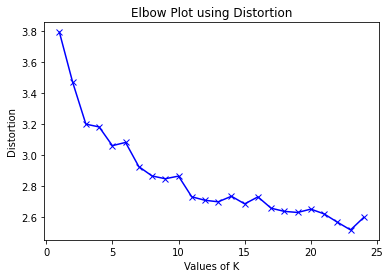

In [28]:
cluster_choose_em(X1, 25, "shoppers")

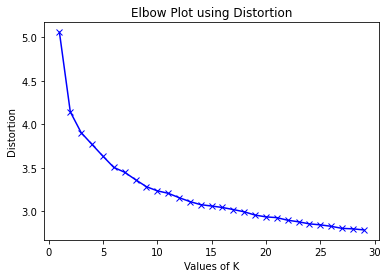

In [29]:
cluster_choose_em(X2, 30, "cancer")

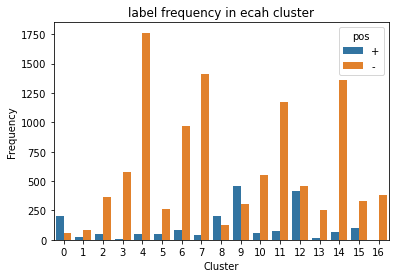

F1 Score:  0.53
Accuracy:  0.88


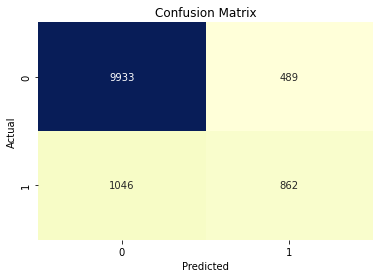

In [50]:
apply_EM(X1, y1, 17, "shoppers")

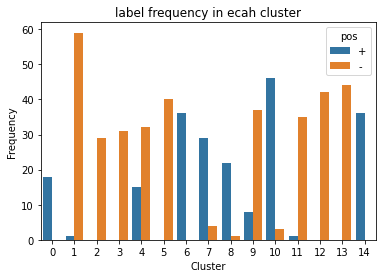

F1 Score:  0.92
Accuracy:  0.94


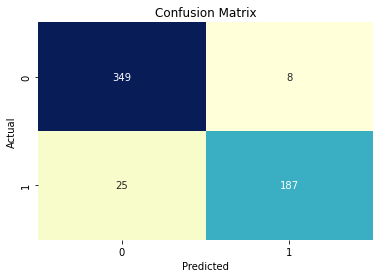

In [51]:
apply_EM(X2, y2, 15 , "cancer")

# Dimention Reduction

In [28]:
def apply_PCA(X,y,name):   
    pca = PCA(random_state=2).fit(X)
    cum_var = np.cumsum(pca.explained_variance_ratio_)

    fig, ax1 = plt.subplots()
    ax1.plot(list(range(len(pca.explained_variance_ratio_))), cum_var, 'g-')
    ax1.set_xlabel('Principal Components')
    ax1.set_ylabel('Cumulative Variance Explained', color='green')
    ax1.tick_params('y', colors='green')

    ax2 = ax1.twinx()
    sns.barplot(x=list(range(len(pca.singular_values_))), y=pca.explained_variance_, ax=ax2)
    ax2.set(xlabel="Components", ylabel="Variance Explained")
#     ax2.plot(list(range(len(pca.singular_values_))), pca.singular_values_, 'm-')
#     ax2.set_ylabel('Eigenvalues', color='m')
    ax2.tick_params('y')
    plt.title("PCA Variance and Eigenvalues")
    fig.tight_layout()
    plt.savefig('./'+name+'PCA.png')
    plt.show()
    
def apply_ICA(X,y,name):  
    xes = list(np.arange(2,(X.shape[1]-1),3))
    xes.append(X.shape[1])
    ica = FastICA(random_state=2)
    kurts = []
    rmses = []
    for i in xes:
        ica.set_params(n_components=i)
        p = pd.DataFrame(ica.fit_transform(X))
        rmse = mean_squared_error(X, np.dot(p, ica.mixing_.T) + ica.mean_, squared=False)
        p = p.kurt(axis=0)
        kurts.append(p.abs().mean())
        rmses.append(rmse)

    plt.figure()
    plt.title("ICA Kurtosis Plot")
    plt.xlabel("Components")
    plt.ylabel("Kurtosis")
    plt.plot(xes, kurts, 'g-')
    plt.savefig('./'+name+'ICA_kurt.png')
    plt.show()
    
    ax = sns.regplot(xes, rmses)
    ax.set_title("Mean Sqaure Error Plot", fontsize=16)
    ax.set(xlabel="Components", ylabel="RMSE")
    plt.savefig('./'+name+'ICA_rmse.png')
    plt.show()

def apply_RCA(X,y,name):  
    n_cols = len(X.columns)
    rang = range(1, n_cols + 1)
    re = defaultdict(dict)

    for i, n in product(range(30), rang):
        rp = random_projection.GaussianRandomProjection(random_state=i, n_components=n)
        X_Reduced = rp.fit_transform(X)
        p_inverse = np.linalg.pinv(rp.components_.T)
        Recon_X = X_Reduced.dot(p_inverse)
        MSE_RE = mean_squared_error(X, Recon_X)
        re[n][i] = MSE_RE

    rec = pd.DataFrame(re).T
    re_mean = rec.mean(axis=1).tolist()
    re_std = rec.std(axis=1).tolist()
    lower_axis = []
    upper_axis = []

    zip_object = zip(re_mean, re_std)
    for list1_i, list2_i in zip_object:
        lower_axis.append(list1_i - list2_i)
        upper_axis.append(list1_i + list2_i)

#         print('-----')
#         print(re_mean)
#         print(re_std)
    fig, ax1 = plt.subplots()
    ax1.plot(rang, re_mean, 'g-')
    ax1.fill_between(rang, lower_axis, upper_axis, alpha=0.3)
    ax1.set_xlabel('Components Number')
    ax1.set_ylabel('Error')
    ax1.tick_params('y')
    ax1.tick_params('x')
    plt.title("RCA Mean Reconstruction Error")
    fig.tight_layout()
    plt.savefig('./'+name+'RCA.png')
    plt.show()
#     xes = list(np.arange(2,(X.shape[1]-1),5))
#     xes.append(X.shape[1])
#     p = defaultdict(dict)

#     for dim in xes:
#         print(dim)
#         rp = random_projection.SparseRandomProjection(random_state=2, n_components=dim)
#         X2 = rp.fit_transform(X)
#         dists = euclidean_distances(X, squared=True).ravel()
#         nonzero = dists != 0
#         dists = dists[nonzero]
#         projected_dists = euclidean_distances(
#         X2, squared=True).ravel()[nonzero]
# #         min_dist = min(projected_dists.min(), dists.min())
# #         max_dist = max(projected_dists.max(), dists.max())
#         p[dim] = np.corrcoef(dists,projected_dists)[0,1]
#         print(p[dim])
#     p = pd.DataFrame(p).T
#     means = p.mean(axis=1).tolist()
#     stds = p.std(axis=1).tolist()

#     fig, ax1 = plt.subplots()
#     ax1.plot(xes,means, 'b-')
#     ax1.set_xlabel('Components')
#     ax1.set_ylabel('Mean Correlation', color='green')
#     ax1.tick_params('y', colors='green')

#     ax2 = ax1.twinx()
#     ax2.plot(xes,stds, 'm-')
#     ax2.set_ylabel('STD Correlation', color='m')
#     ax2.tick_params('y', colors='m')

#     plt.title("Random Components Plot")
#     fig.tight_layout()
#     plt.savefig('./'+name+'RCA.png')
#     plt.show()
    
def apply_RFC(X,y,df):
    rfc = RandomForestClassifier(n_estimators=500,min_samples_leaf=round(len(X)*.01),random_state=2)
    importances = rfc.fit(X,y).feature_importances_ 
    importances = pd.DataFrame(importances,columns=['Importance'],index=df.columns[1::])
    importances.sort_values(by=['Importance'],inplace=True,ascending=False)
    importances['Cum Sum'] = importances['Importance'].cumsum()
    importances = importances[importances['Cum Sum']<=0.95]
    cols = importances.index.tolist()
    return importances, cols

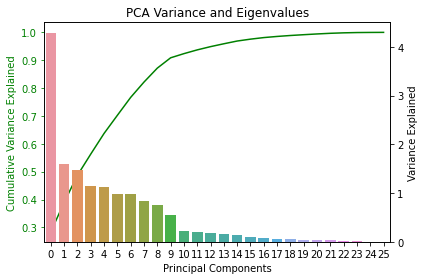

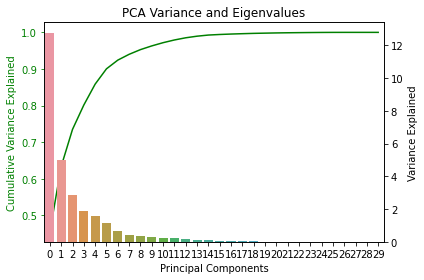

In [64]:
apply_PCA(X1,y1,"shoppers")
apply_PCA(X2,y2,"cancer")

/Users/zj88zj/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
/Users/zj88zj/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
/Users/zj88zj/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
/Users/zj88zj/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
/Users/zj88zj/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: Conve

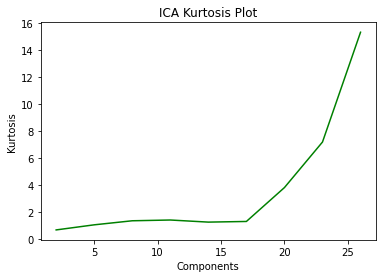

/Users/zj88zj/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


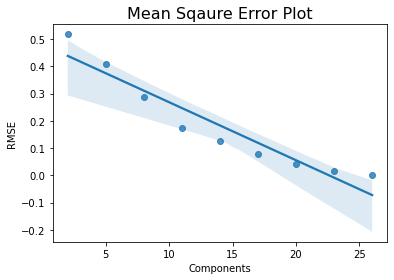

/Users/zj88zj/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
/Users/zj88zj/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
/Users/zj88zj/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,


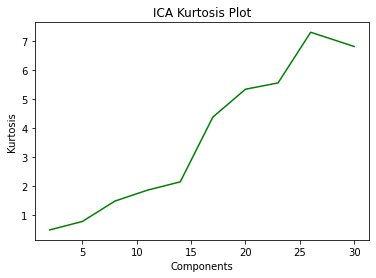

/Users/zj88zj/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


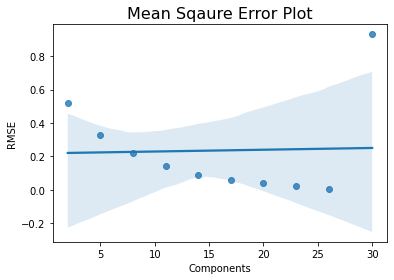

In [72]:
apply_ICA(X1,y1,"shoppers")
apply_ICA(X2,y2,"cancer")

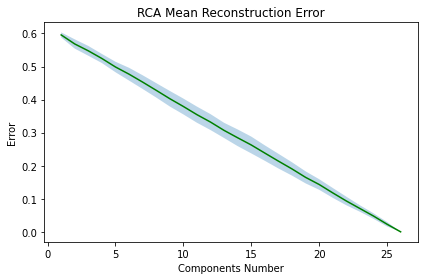

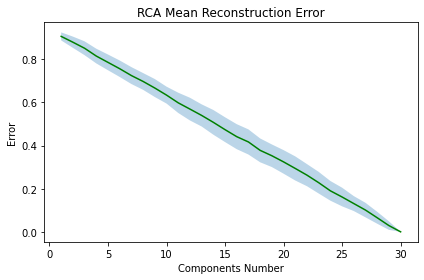

In [29]:
apply_RCA(X1,y1,"shoppers")
apply_RCA(X2,y2,"cancer")

In [25]:
importances_shoppers, cols_shoppers = apply_RFC(X1,y1,df1)
importances_cancer, cols_cancer = apply_RFC(X2,y2,df2)

In [31]:
importances_shoppers

,Importance,Cum Sum
SpecialDay,0.650662,0.650662
PageValues,0.080314,0.730976
BounceRates,0.060212,0.791189
Month_Oct,0.040228,0.831417
ExitRates,0.040181,0.871598
ProductRelated_Duration,0.038299,0.909897
Administrative_Duration,0.025183,0.935080


In [30]:
importances_cancer

,Importance,Cum Sum
texture_worst,0.166004,0.166004
symmetry_mean,0.135151,0.301154
area_worst,0.134862,0.436016
symmetry_worst,0.133643,0.569659
texture_mean,0.079893,0.649551
concave points_mean,0.065035,0.714586
area_mean,0.055430,0.770017
concave points_worst,0.042501,0.812518
smoothness_se,0.041739,0.854256
texture_se,0.019875,0.874131


## Run Clustering on Reducted Data

In [32]:
pca_shoppers = PCA(n_components=15,random_state=2).fit_transform(X1)
ica_shoppers = FastICA(n_components=17,random_state=2).fit_transform(X1)
rca_shoppers = random_projection.GaussianRandomProjection(n_components=15,random_state=2).fit_transform(X1)
rf_shoppers = df1[cols_shoppers]

C:\Users\jzhang\Anaconda\lib\site-packages\sklearn\decomposition\_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


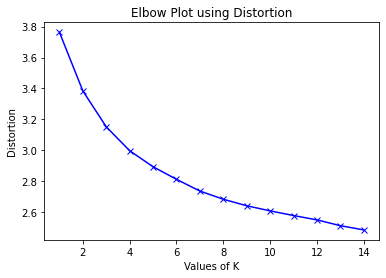

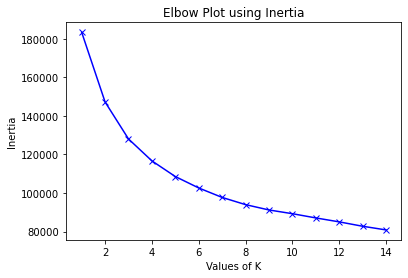

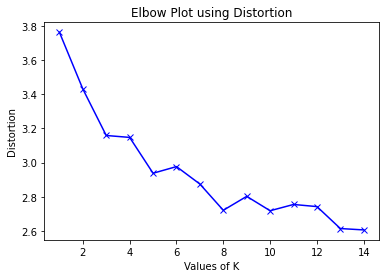

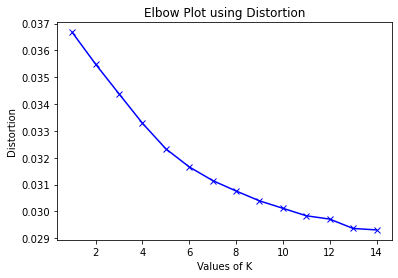

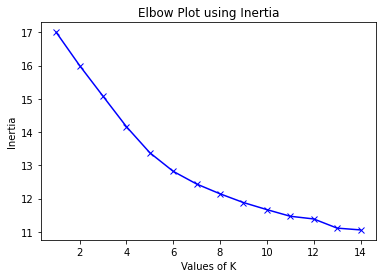

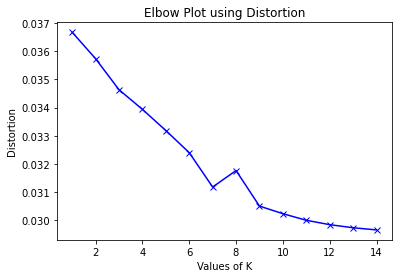

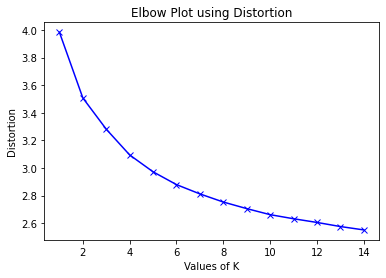

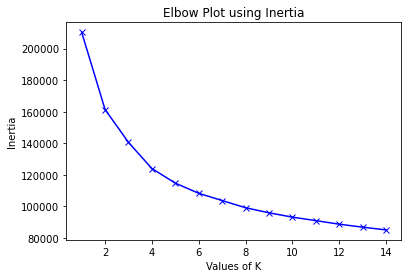

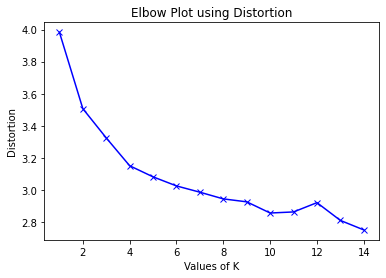

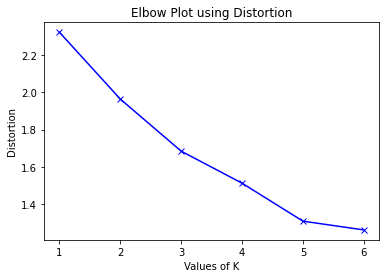

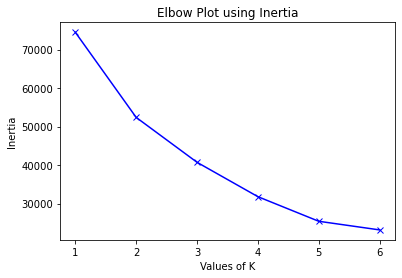

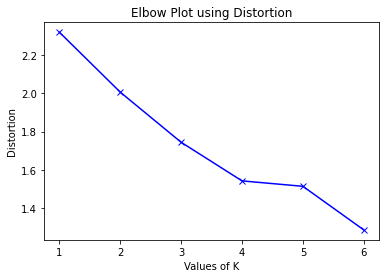

In [38]:
cluster_choose_km(pca_shoppers, 15, 'PCA_shoppers')
cluster_choose_em(pca_shoppers, 15, 'PCA_shoppers')

cluster_choose_km(ica_shoppers, 15, 'ICA_shoppers')
cluster_choose_em(ica_shoppers, 15, 'ICA_shoppers')

cluster_choose_km(rca_shoppers, 15, 'RCA_shoppers')
cluster_choose_em(rca_shoppers, 15, 'RCA_shoppers')

cluster_choose_km(rf_shoppers, 7, 'RF_shoppers')
cluster_choose_em(rf_shoppers, 7, 'RF_shoppers')

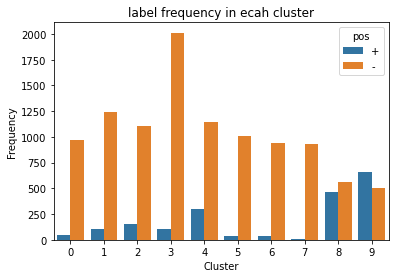

F1 Score:  0.43
Accuracy:  0.86


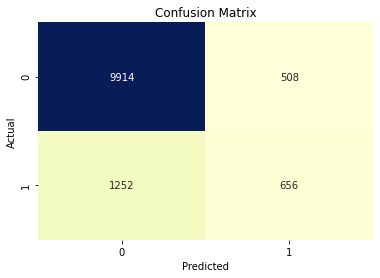

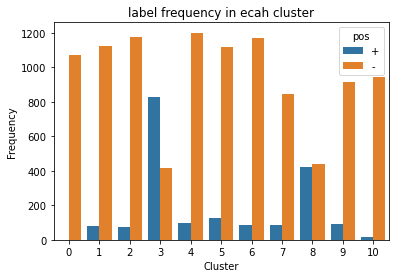

F1 Score:  0.53
Accuracy:  0.88


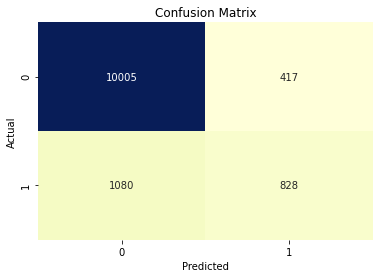

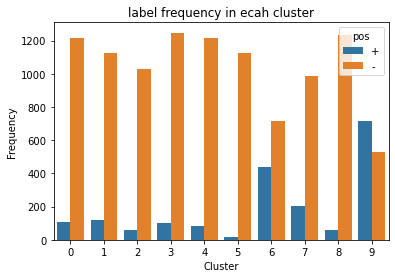

F1 Score:  0.45
Accuracy:  0.86


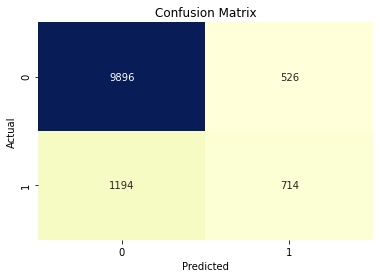

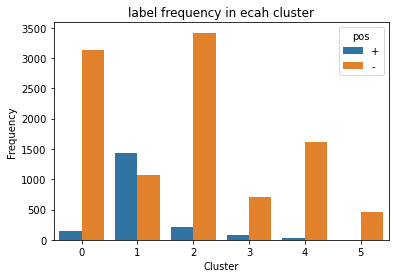

F1 Score:  0.65
Accuracy:  0.88


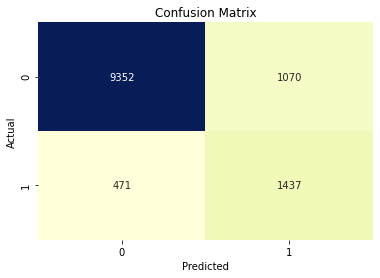

In [39]:
apply_kmeans(pca_shoppers,y1,10,'PCA_shoppers')
apply_kmeans(ica_shoppers,y1,11,'ICA_shoppers')
apply_kmeans(rca_shoppers,y1,10,'RCA_shoppers')
apply_kmeans(rf_shoppers,y1,6,'RF_shoppers')

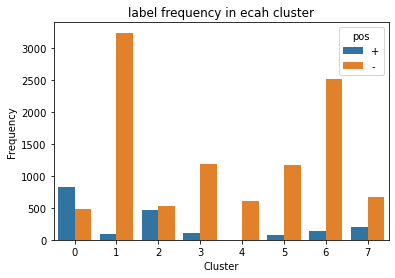

F1 Score:  0.51
Accuracy:  0.87


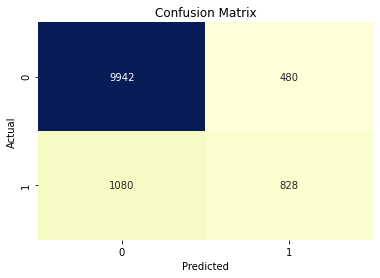

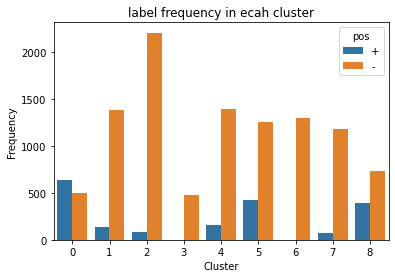

F1 Score:  0.42
Accuracy:  0.86


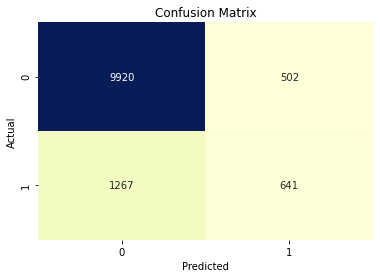

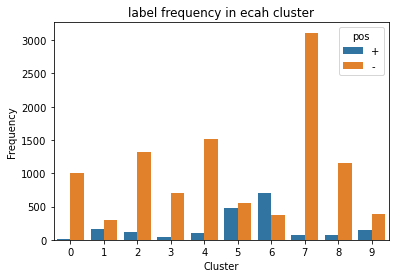

F1 Score:  0.47
Accuracy:  0.87


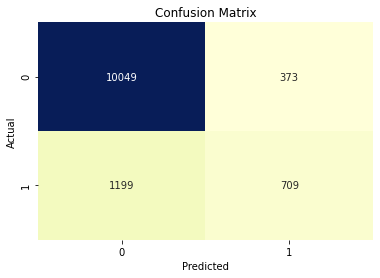

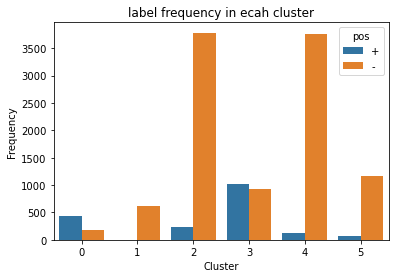

F1 Score:  0.65
Accuracy:  0.88


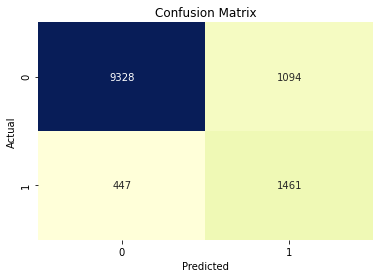

In [40]:
apply_EM(pca_shoppers,y1,8,'PCA_shoppers')
apply_EM(ica_shoppers,y1,9,'ICA_shoppers')
apply_EM(rca_shoppers,y1,10,'RCA_shoppers')
apply_EM(rf_shoppers,y1,6,'RF_shoppers')

In [42]:
pca_cancer = PCA(n_components=15,random_state=2).fit_transform(X2)
ica_cancer = FastICA(n_components=20,random_state=2).fit_transform(X2)
rca_cancer = random_projection.GaussianRandomProjection(n_components=20,random_state=2).fit_transform(X2)
rf_cancer = df2[cols_cancer]

C:\Users\jzhang\Anaconda\lib\site-packages\sklearn\decomposition\_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


C:\Users\jzhang\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


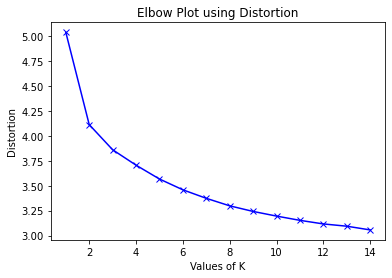

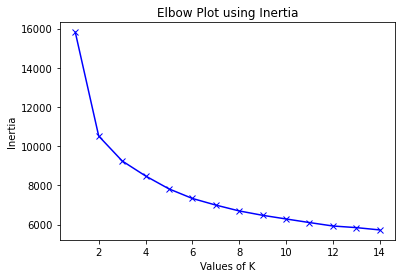

C:\Users\jzhang\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


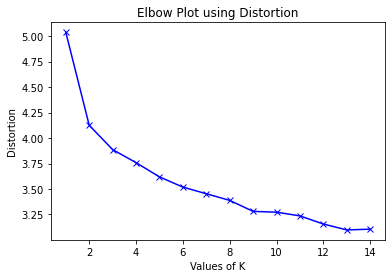

C:\Users\jzhang\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


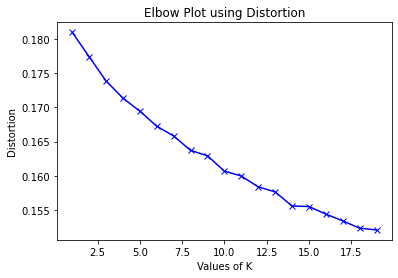

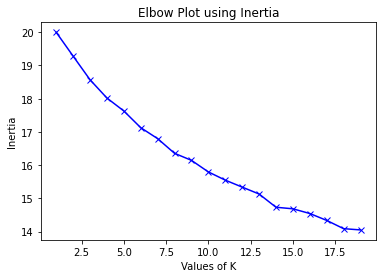

C:\Users\jzhang\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


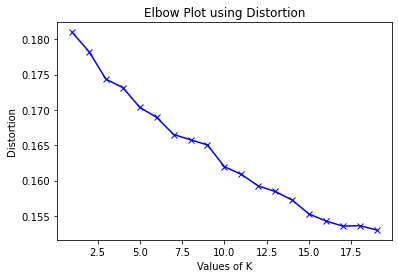

C:\Users\jzhang\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


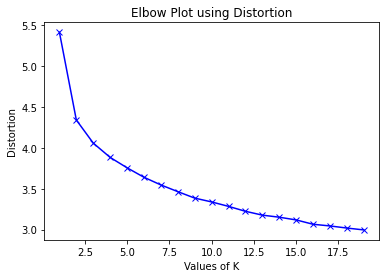

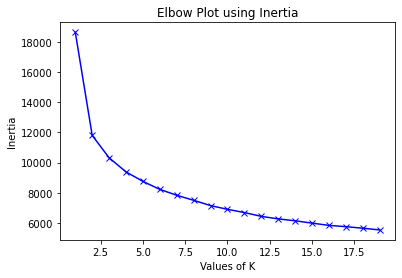

C:\Users\jzhang\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


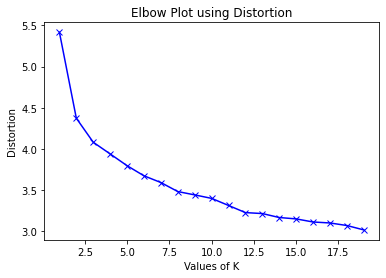

C:\Users\jzhang\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


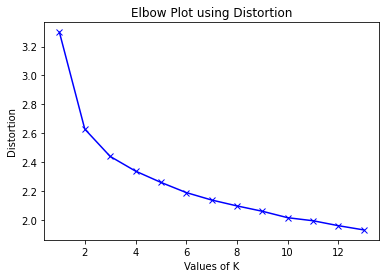

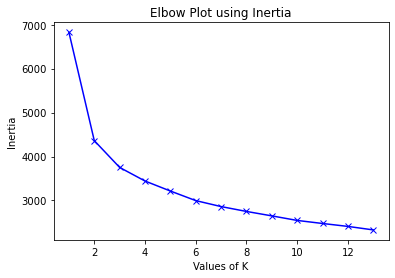

C:\Users\jzhang\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


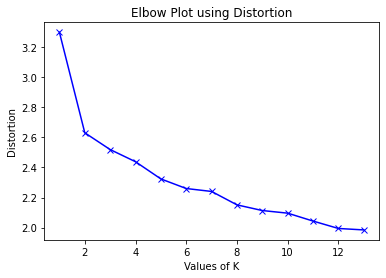

In [43]:
cluster_choose_km(pca_cancer, 15, 'PCA_cancer')
cluster_choose_em(pca_cancer, 15, 'PCA_cancer')

cluster_choose_km(ica_cancer, 20, 'ICA_cancer')
cluster_choose_em(ica_cancer, 20, 'ICA_cancer')

cluster_choose_km(rca_cancer, 20, 'RCA_cancer')
cluster_choose_em(rca_cancer, 20, 'RCA_cancer')

cluster_choose_km(rf_cancer, 14, 'RF_cancer')
cluster_choose_em(rf_cancer, 14, 'RF_cancer')

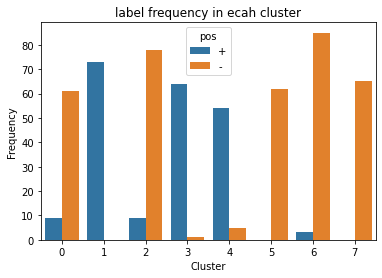

F1 Score:  0.93
Accuracy:  0.95


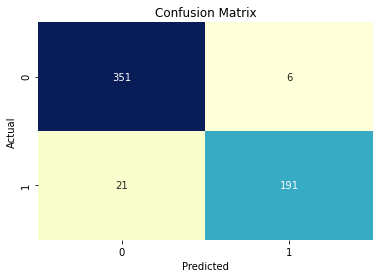

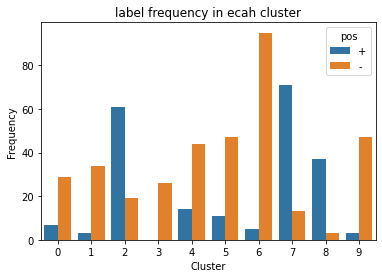

F1 Score:  0.81
Accuracy:  0.86


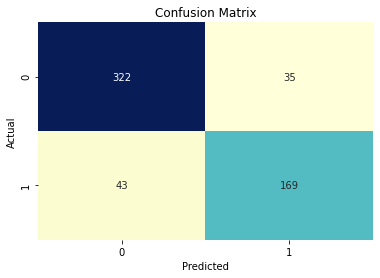

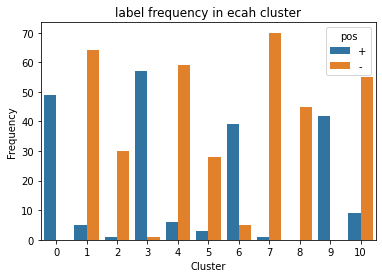

F1 Score:  0.92
Accuracy:  0.95


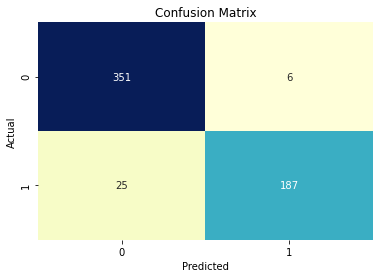

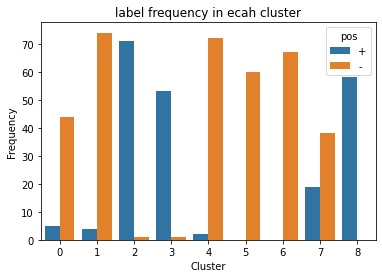

F1 Score:  0.92
Accuracy:  0.94


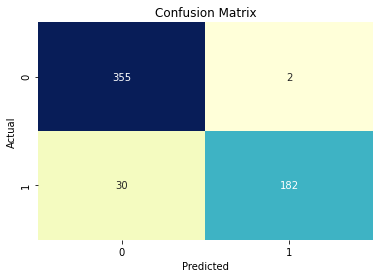

In [59]:
apply_kmeans(pca_cancer,y2,8,'PCA_cancer')
apply_kmeans(ica_cancer,y2,10,'ICA_cancer')
apply_kmeans(rca_cancer,y2,11,'RCA_cancer')
apply_kmeans(rf_cancer,y2,9,'RF_cancer')

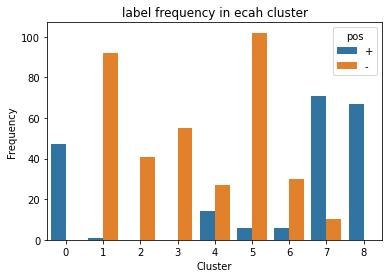

F1 Score:  0.91
Accuracy:  0.93


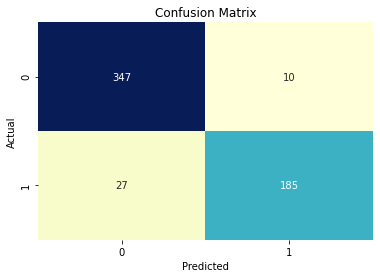

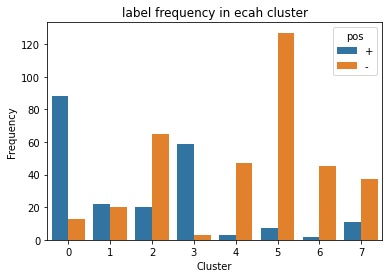

F1 Score:  0.81
Accuracy:  0.86


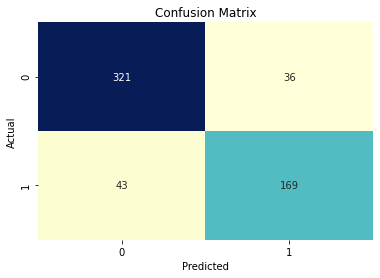

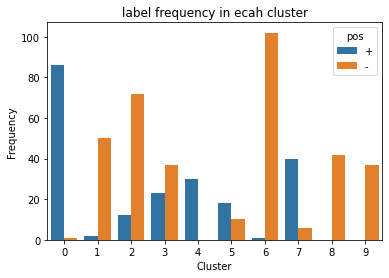

F1 Score:  0.86
Accuracy:  0.90


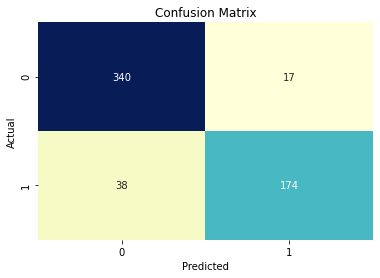

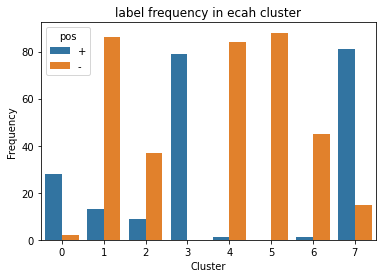

F1 Score:  0.90
Accuracy:  0.93


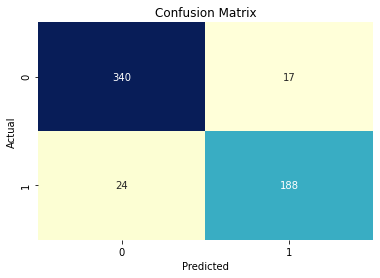

In [71]:
apply_EM(pca_cancer,y2,9,'PCA_cancer')
apply_EM(ica_cancer,y2,8,'ICA_cancer')
apply_EM(rca_cancer,y2,10,'RCA_cancer')
apply_EM(rf_cancer,y2,8,'RF_cancer')

## Neural Network on Reduced data 1

In [141]:
def plot_learning_curve(clf, X, y, name):
    n = len(y)
    train_mean = []; train_std = [] 
    cv_mean = []; cv_std = [] 
    fit_mean = []; fit_std = [] 
    pred_mean = []; pred_std = []
    train_sizes=(np.linspace(.05, 1.0, 20)*n).astype('int')  
    
    for i in train_sizes:
        idx = np.random.randint(X.shape[0], size=i)
        X_subset = X[idx,:]
        y_subset = y[idx]
        scores = cross_validate(clf, X_subset, y_subset, cv=10, scoring='f1',return_train_score=True)
        
        train_mean.append(np.mean(scores['train_score'])); train_std.append(np.std(scores['train_score']))
        cv_mean.append(np.mean(scores['test_score'])); cv_std.append(np.std(scores['test_score']))
        fit_mean.append(np.mean(scores['fit_time'])); fit_std.append(np.std(scores['fit_time']))
        pred_mean.append(np.mean(scores['score_time'])); pred_std.append(np.std(scores['score_time']))
    
    train_mean = np.array(train_mean); train_std = np.array(train_std)
    cv_mean = np.array(cv_mean); cv_std = np.array(cv_std)
    fit_mean = np.array(fit_mean); fit_std = np.array(fit_std)
    pred_mean = np.array(pred_mean); pred_std = np.array(pred_std)
    
    plt.figure()
    plt.title("Learning Curve")
    plt.xlabel("Training Examples")
    plt.ylabel("Model F1 Score")
    plt.fill_between(train_sizes, train_mean - 2*train_std, train_mean + 2*train_std, alpha=0.1, color="g")
    plt.fill_between(train_sizes, cv_mean - 2*cv_std, cv_mean + 2*cv_std, alpha=0.1, color="r")
    plt.plot(train_sizes, train_mean, 'o-', color="g", label="Training Score")
    plt.plot(train_sizes, cv_mean, 'o-', color="r", label="Cross-Validation Score")
    plt.legend(loc="best")
    plt.savefig('./'+name+'NN_lc.png')
    plt.show()
    
    plt.figure()
    plt.title("Modeling Time")
    plt.xlabel("Training Examples")
    plt.ylabel("Training Time (s)")
    plt.fill_between(train_sizes, fit_mean - 2*fit_std, fit_mean + 2*fit_std, alpha=0.1, color="g")
    plt.fill_between(train_sizes, pred_mean - 2*pred_std, pred_mean + 2*pred_std, alpha=0.1, color="r")
    plt.plot(train_sizes, fit_mean, '-', color="g", label="Training Time (s)")
    plt.plot(train_sizes, pred_std, '-', color="r", label="Prediction Time (s)")
    plt.legend(loc="best")
    plt.savefig('./'+name+'_NN_time.png')
    plt.show()
    
    return train_sizes, train_mean, fit_mean, pred_mean

def final_classifier_evaluation(clf,X_train, X_test, y_train, y_test, name):
    
    start_time = timeit.default_timer()
    clf.fit(X_train, y_train)
    end_time = timeit.default_timer()
    training_time = end_time - start_time
    
    start_time = timeit.default_timer()    
    y_pred = clf.predict(X_test)
    end_time = timeit.default_timer()
    pred_time = end_time - start_time
    
    auc = roc_auc_score(y_test, y_pred)
    f1 = f1_score(y_test,y_pred)
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred)
    recall = recall_score(y_test,y_pred)
    cm = confusion_matrix(y_test,y_pred)
    
    clf.fit(X_train, y_train)
    train_loss = clf.loss_curve_
    clf.fit(X_test, y_test)
    test_loss = clf.loss_curve_

    plt.figure()
    plt.title("Loss Curve")
    plt.plot(train_loss, label="Testing")
    plt.plot(test_loss, label="Training")
    plt.xlim(0, 150)
    plt.xlabel("Number of Iterations")
    plt.ylabel("Loss")
    plt.legend(loc="best")
    plt.savefig('./'+name+'NN_Loss.png')
    plt.show()

    print("Model Training Time (s):   "+"{:.5f}".format(training_time))
    print("Model Prediction Time (s): "+"{:.5f}\n".format(pred_time))
    print("F1 Score:  "+"{:.2f}".format(f1))
    print("Accuracy:  "+"{:.2f}".format(accuracy))
    
    plot_roc_curve(clf,X_train,y_train)
    plt.title('ROC Curve')
    plt.savefig('./'+name+'NN_ROC.png')
    plt.show()
    
    sns.heatmap(pd.DataFrame(cm),annot=True,fmt='d',cbar=False, cmap="YlGnBu")
    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.savefig('./'+name+'NN_confusion_matrix.png')
    plt.show()
    
    return training_time, pred_time,f1, accuracy

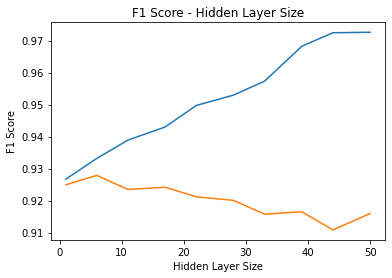

In [11]:
f_test = []
f_train = []
units = np.linspace(1,50,10).astype('int')
for i in units:         
    nn = MLPClassifier(hidden_layer_sizes=(i,), learning_rate_init=0.01, solver='adam', activation='logistic', random_state=0, max_iter=800)
    nn.fit(X_train, y_train)
    y_pred_train = nn.predict(X_train)
    y_pred_test = nn.predict(X_test)
    f_train.append(f1_score(y_train, y_pred_train))
    f_test.append(f1_score(y_test, y_pred_test))

plt.plot(units, f_train, label='Training')
plt.plot(units, f_test, label='Testing')
plt.ylabel('F1 Score')
plt.xlabel('Hidden Layer Size')
plt.title("F1 Score - Hidden Layer Size")
plt.savefig('./f1-NNunit.png')
plt.show()

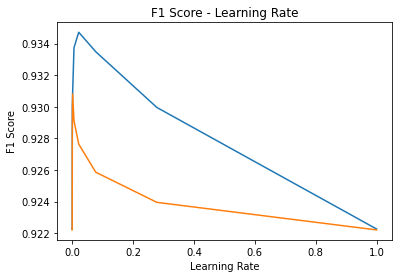

In [12]:
f_test = []
f_train = []
lrs = np.logspace(-5, 0, 10)
for i in lrs:         
    nn = MLPClassifier(hidden_layer_sizes=(5,), learning_rate_init=i, solver='adam', activation='logistic', random_state=0, max_iter=800)
    nn.fit(X_train, y_train)
    y_pred_train = nn.predict(X_train)
    y_pred_test = nn.predict(X_test)
    f_train.append(f1_score(y_train, y_pred_train))
    f_test.append(f1_score(y_test, y_pred_test))

plt.plot(lrs, f_train, label='Training')
plt.plot(lrs, f_test, label='Testing')
plt.ylabel('F1 Score')
plt.xlabel('Learning Rate')
plt.title("F1 Score - Learning Rate")
plt.savefig('./f1-NNlr.png')
plt.show()

In [ ]:
print("Best hidden size",nn.best_params_['hidden_layer_sizes'])
print("Best learning rate",nn.best_params_['learning_rate_init'])

hs = nn.best_params_['hidden_layer_sizes']
lr = nn.best_params_['learning_rate_init']

C:\Users\jzhang\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (800) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jzhang\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (800) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jzhang\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (800) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jzhang\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (800) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jzhang\Anaconda\lib\site-packages\sklearn\neural_network\_multi

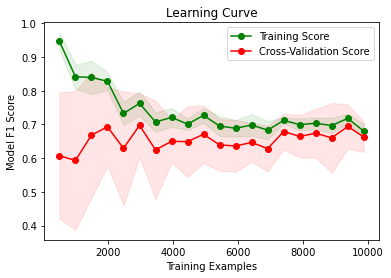

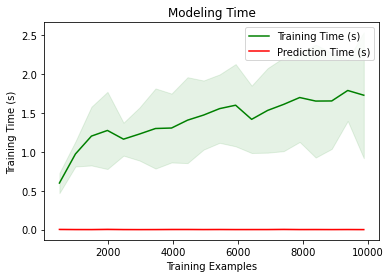

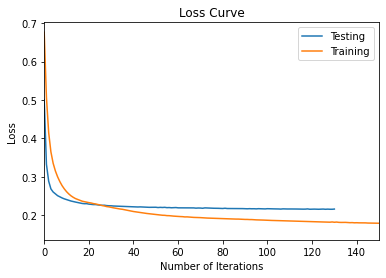

Model Training Time (s):   1.76306
Model Prediction Time (s): 0.00178

F1 Score:  0.70
Accuracy:  0.92


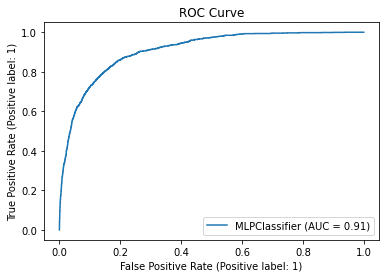

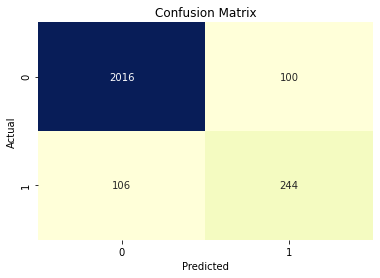

In [103]:
full_est = MLPClassifier(hidden_layer_sizes=(5,), solver='adam', activation='logistic', learning_rate_init=0.01, random_state=2, max_iter = 800)
train_sizes, train_mean, fit_mean, pred_mean = plot_learning_curve(full_est, X1_train, y1_train,"NN Shoppers Original")
train_time, pred_time, f1, accuracy = final_classifier_evaluation(full_est, X1_train, X1_test, y1_train, y1_test,"NN Shoppers Original")

C:\Users\jzhang\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (800) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jzhang\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (800) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jzhang\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (800) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jzhang\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (800) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jzhang\Anaconda\lib\site-packages\sklearn\neural_network\_multi

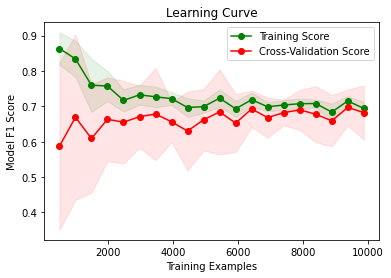

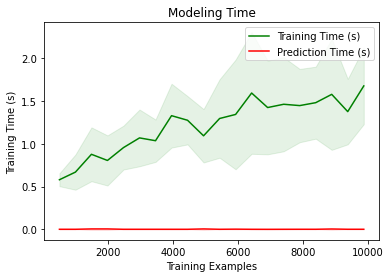

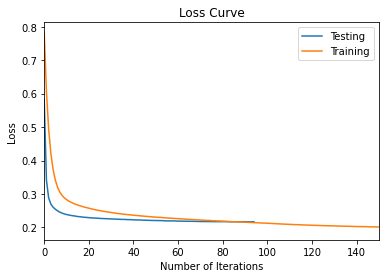

Model Training Time (s):   1.18946
Model Prediction Time (s): 0.00077

F1 Score:  0.67
Accuracy:  0.90


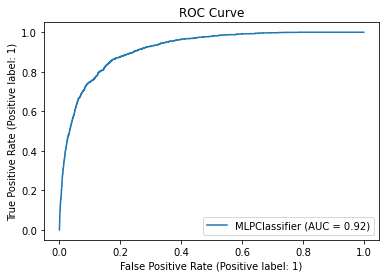

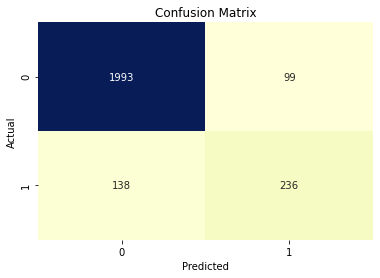

In [142]:
X_train, X_test, y_train, y_test = train_test_split(np.array(pca_shoppers), np.array(y1), test_size=0.20)
pca_est = MLPClassifier(hidden_layer_sizes=(5,), solver='adam', activation='logistic', learning_rate_init=0.01, random_state=2, max_iter=800)
train_sizes_pca, train_mean_pca, fit_mean_pca, pred_mean_pca = plot_learning_curve(pca_est, X_train, y_train, "NN Shoppers PCA")
train_time_pca, pred_time_pca, f1_pca, accuracy_pca = final_classifier_evaluation(pca_est, X_train, X_test, y_train, y_test, "NN Shoppers PCA")

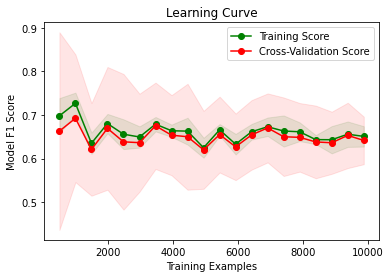

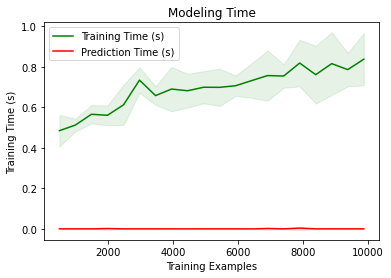

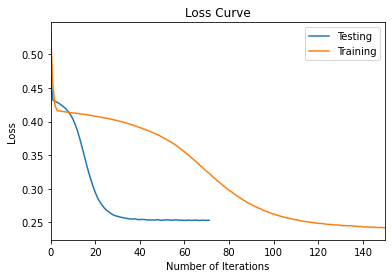

Model Training Time (s):   0.94824
Model Prediction Time (s): 0.00045

F1 Score:  0.61
Accuracy:  0.90


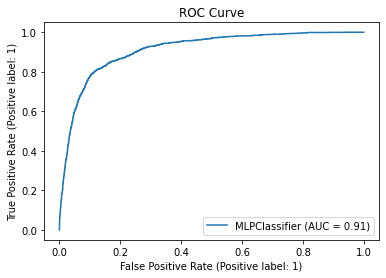

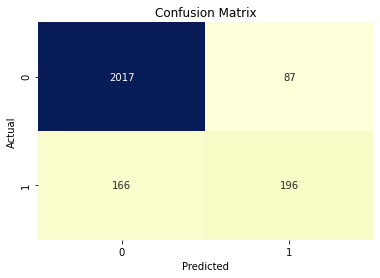

In [143]:
X_train, X_test, y_train, y_test = train_test_split(np.array(ica_shoppers), np.array(y1), test_size=0.20)
ica_est = MLPClassifier(hidden_layer_sizes=(5,), solver='adam', activation='logistic', learning_rate_init=0.01, random_state=2, max_iter=800)
train_sizes_ica, train_mean_ica, fit_mean_ica, pred_mean_ica = plot_learning_curve(ica_est, X_train, y_train, "NN Shoppers ICA")
train_time_ica, pred_time_ica, f1_ica, accuracy_ica = final_classifier_evaluation(ica_est, X_train, X_test, y_train, y_test, "NN Shoppers ICA")

C:\Users\jzhang\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (800) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jzhang\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (800) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jzhang\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (800) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jzhang\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (800) reached and the optimization hasn't converged yet.
  warnings.warn(


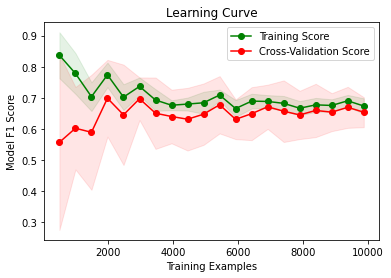

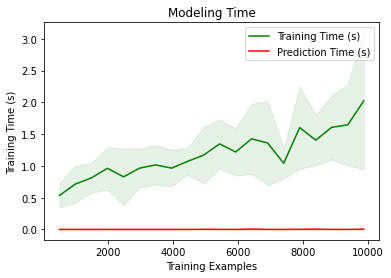

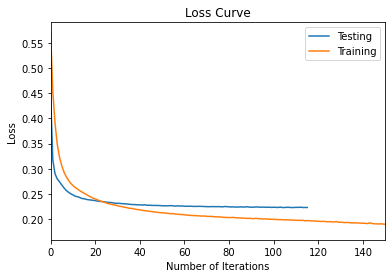

Model Training Time (s):   1.46893
Model Prediction Time (s): 0.00049

F1 Score:  0.69
Accuracy:  0.91


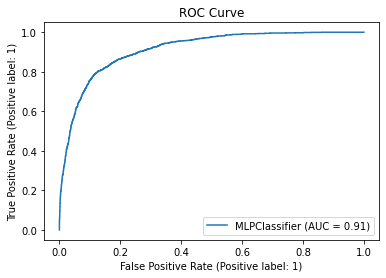

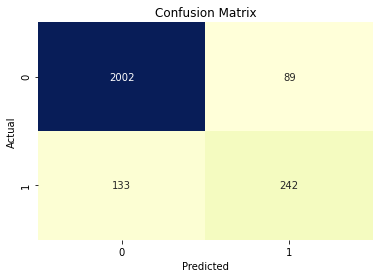

In [144]:
X_train, X_test, y_train, y_test = train_test_split(np.array(rca_shoppers), np.array(y1), test_size=0.20)
rca_est = MLPClassifier(hidden_layer_sizes=(5,), solver='adam', activation='logistic', learning_rate_init=0.01, random_state=2, max_iter=800)
train_sizes_rca, train_mean_rca, fit_mean_rca, pred_mean_rca = plot_learning_curve(rca_est, X_train, y_train, "NN Shoppers RCA")
train_time_rca, pred_time_rca, f1_rca, accuracy_rca = final_classifier_evaluation(rca_est, X_train, X_test, y_train, y_test, "NN Shoppers RCA")

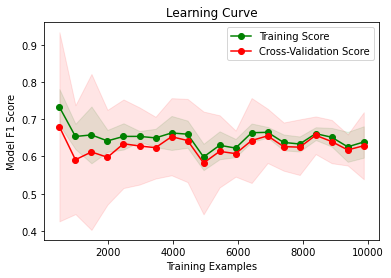

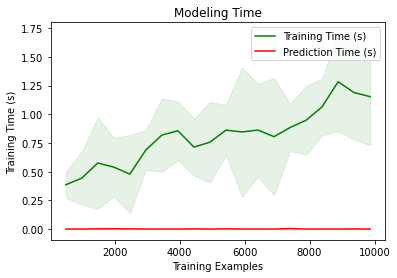

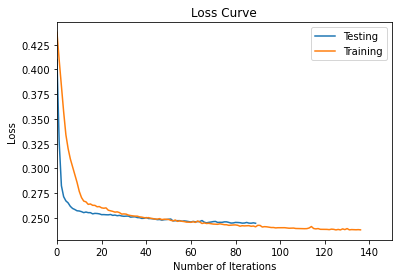

Model Training Time (s):   1.10539
Model Prediction Time (s): 0.00050

F1 Score:  0.63
Accuracy:  0.90


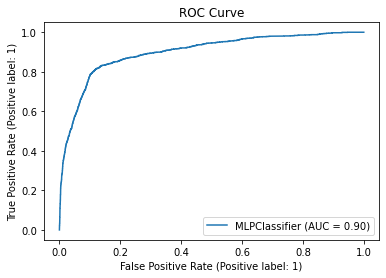

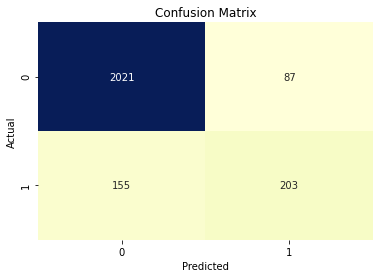

In [145]:
X_train, X_test, y_train, y_test = train_test_split(np.array(rf_shoppers), np.array(y1), test_size=0.20)
rf_est = MLPClassifier(hidden_layer_sizes=(5,), solver='adam', activation='logistic', learning_rate_init=0.01, random_state=2, max_iter=800)
train_sizes_rf, train_mean_rf, fit_mean_rf, pred_mean_rf = plot_learning_curve(rf_est, X_train, y_train, "NN Shoppers RF")
train_time_rf, pred_time_rf, f1_rf, accuracy_rf = final_classifier_evaluation(rf_est, X_train, X_test, y_train, y_test, "NN Shoppers RF")

In [146]:
def compare_plots(
    n, 
    train_mean, train_mean_pca,train_mean_ica,train_mean_rca,train_mean_rf,
    fit_mean, fit_mean_pca,fit_mean_ica,fit_mean_rca,fit_mean_rf,
    pred_mean,pred_mean_pca,pred_mean_ica,pred_mean_rca,pred_mean_rf
    ,name):
    
    plt.figure()
    plt.title("Training Times Comparision")
    plt.xlabel("Training Size")
    plt.ylabel("Training Time")
    plt.plot(n, fit_mean, '-', color="k", label="Original")
    plt.plot(n, fit_mean_pca, '-', color="b", label="PCA")
    plt.plot(n, fit_mean_ica, '-', color="r", label="ICA")
    plt.plot(n, fit_mean_rca, '-', color="g", label="RCA")
    plt.plot(n, fit_mean_rf, '-', color="m", label="RF")
    plt.legend(loc="best")
    plt.savefig('./'+name+'NN_TrainTime_Compare.png')
    plt.show()
   
    plt.figure()
    plt.title("Prediction Times Comparison")
    plt.xlabel("Training Size")
    plt.ylabel("Prediction Time")
    plt.plot(n, pred_mean, '-', color="k", label="Original")
    plt.plot(n, pred_mean_pca, '-', color="b", label="PCA")
    plt.plot(n, pred_mean_ica, '-', color="r", label="ICA")
    plt.plot(n, pred_mean_rca, '-', color="g", label="RCA")
    plt.plot(n, pred_mean_rf, '-', color="m", label="RF")
    plt.legend(loc="best")
    plt.savefig('./'+name+'NN_PredTime_Compare.png')
    plt.show()

    plt.figure()
    plt.title("Learning Curves Comparison")
    plt.xlabel("Training Size")
    plt.ylabel("F1 Score")
    plt.plot(n, train_mean, '-', color="k", label="Original")
    plt.plot(n, train_mean_pca, '-', color="b", label="PCA")
    plt.plot(n, train_mean_ica, '-', color="r", label="ICA")
    plt.plot(n, train_mean_rca, '-', color="g", label="RCA")
    plt.plot(n, train_mean_rf, '-', color="m", label="RF")
    plt.legend(loc="best")
    plt.savefig('./'+name+'NN_LC_Compare.png')
    plt.show() 

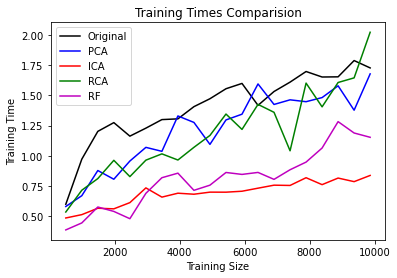

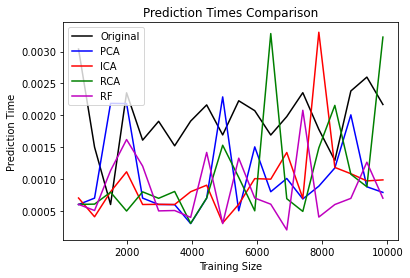

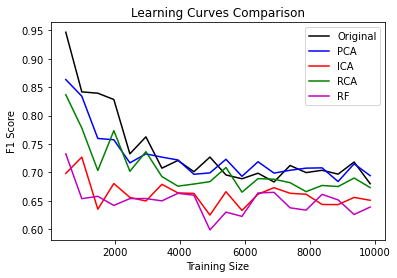

In [147]:
compare_plots(train_sizes, 
    train_mean, train_mean_pca,train_mean_ica,train_mean_rca,train_mean_rf,
    fit_mean, fit_mean_pca,fit_mean_ica,fit_mean_rca,fit_mean_rf,
    pred_mean,pred_mean_pca,pred_mean_ica,pred_mean_rca,pred_mean_rf
    ,'NN_Shoppers') 

In [148]:
df1 = pd.DataFrame(zip(["Original","PCA","ICA","RCA","RF"],[f1,f1_pca,f1_ica,f1_rca,f1_rf]),columns = ['Model','f1'])
df2 = pd.DataFrame(zip(["Original","PCA","ICA","RCA","RF"],[accuracy, accuracy_pca, accuracy_ica, accuracy_rca, accuracy_rf]),columns = ['Model','acc'])
df3 = pd.DataFrame(zip(["Original","PCA","ICA","RCA","RF"],[train_time, train_time_pca, train_time_ica, train_time_rca, train_time_rf]),columns = ['Model','time_train'])
df4 = pd.DataFrame(zip(["Original","PCA","ICA","RCA","RF"],[pred_time, pred_time_pca, pred_time_ica, pred_time_rca, pred_time_rf]),columns = ['Model','time_test'])

models = pd.merge(pd.merge(pd.merge(df1,df2,on='Model'),df3,on='Model'),df4,on='Model')
models

,Model,f1,acc,time_train,time_test
0,Original,0.703170,0.916464,1.763056,0.001781
1,PCA,0.665726,0.903893,1.189463,0.000772
2,ICA,0.607752,0.897405,0.948239,0.000455
3,RCA,0.685552,0.909976,1.468934,0.000490
4,RF,0.626543,0.901865,1.105390,0.000498


<Figure size 576x576 with 0 Axes>

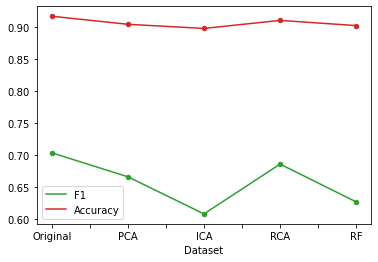

<Figure size 576x576 with 0 Axes>

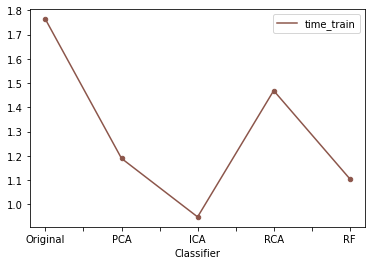

In [150]:
fig = plt.figure(figsize=(8,8))
fig.suptitle('Comparision - Scores')
ax = models.plot(x ="Model", y="f1", kind = "line", label = "F1", color="C2")
models.plot(x ="Model", y="f1", kind = "scatter", ax = ax, color="C2")
models.plot(x ="Model", y="acc", ax = ax, kind = "line", label = "Accuracy",color="C3")
models.plot(x ="Model", y="acc", ax = ax, kind = "scatter", color="C3")

plt.xlabel('Dataset')
plt.ylabel("")
plt.legend(loc="best")
plt.savefig('./Compare_f1_shoppers.png')
plt.show()


fig = plt.figure(figsize=(8,8))
fig.suptitle('Comparision - Time')
ax = models.plot(x ="Model", y="time_train", kind = "line", color="C5")
models.plot(x ="Model", y="time_train", ax = ax,kind = "scatter", color="C5")
plt.xlabel('Classifier')
plt.ylabel("")
plt.legend(loc="best")
plt.savefig('./Compare_time_shoppers.png')
plt.show()

## NN with Clusters

In [151]:
def clustering(X,km_lables,em_lables):
    df = pd.DataFrame(X)
    df['KM Cluster'] = km_labels
    df['EM Cluster'] = em_labels
    col_1hot = ['KM Cluster', 'EM Cluster']
    df_1hot = df[col_1hot]
    df_1hot = pd.get_dummies(df_1hot).astype('category')
    df_others = df.drop(col_1hot,axis=1)
    df = pd.concat([df_others,df_1hot],axis=1) 
    
    return df

In [152]:
km = KMeans(n_clusters=10,n_init=10,random_state=2).fit(X1)
km_labels = km.labels_
em = GaussianMixture(n_components=15,random_state=2).fit(X1)
em_labels = em.predict(X1)

clust_orig = clustering(X1,km_labels,em_labels)
clust_pca = clustering(pca_shoppers,km_labels,em_labels)
clust_ica = clustering(ica_shoppers,km_labels,em_labels)
clust_rca = clustering(rca_shoppers,km_labels,em_labels)
clust_rfc = clustering(rf_shoppers,km_labels,em_labels)

C:\Users\jzhang\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (800) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jzhang\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (800) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jzhang\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (800) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jzhang\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (800) reached and the optimization hasn't converged yet.
  warnings.warn(


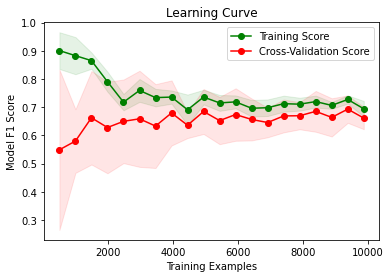

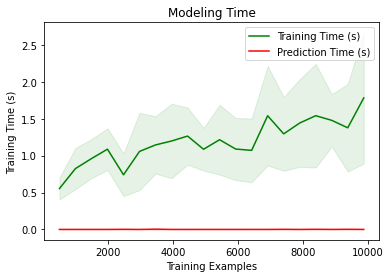

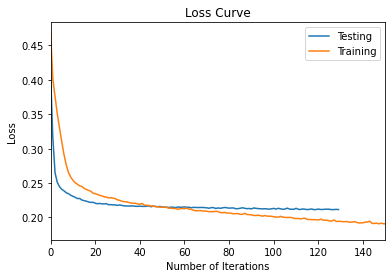

Model Training Time (s):   1.70651
Model Prediction Time (s): 0.00051

F1 Score:  0.66
Accuracy:  0.90


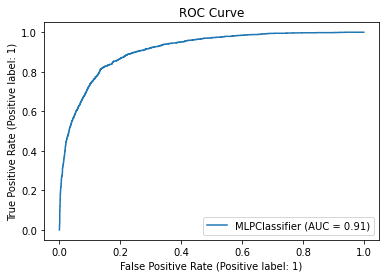

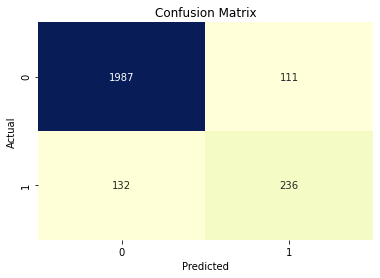

In [153]:
X_train, X_test, y_train, y_test = train_test_split(np.array(clust_orig),np.array(y1), test_size=0.20)
full_est = MLPClassifier(hidden_layer_sizes=(5,), solver='adam', activation='logistic', learning_rate_init=0.01, random_state=2, max_iter = 800)
train_sizes, train_mean, fit_mean, pred_mean = plot_learning_curve(full_est, X_train, y_train,"NN Shoppers Original_Clusters")
train_time, pred_time, f1, accuracy = final_classifier_evaluation(full_est, X_train, X_test, y_train, y_test,"NN Shoppers Original_Clusters")

C:\Users\jzhang\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (800) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jzhang\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (800) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jzhang\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (800) reached and the optimization hasn't converged yet.
  warnings.warn(


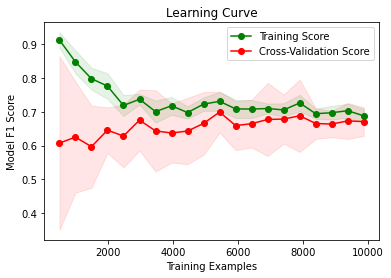

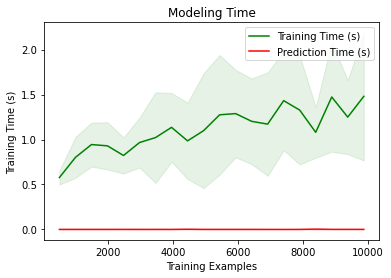

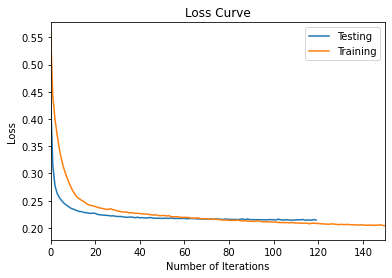

Model Training Time (s):   1.48746
Model Prediction Time (s): 0.00047

F1 Score:  0.66
Accuracy:  0.90


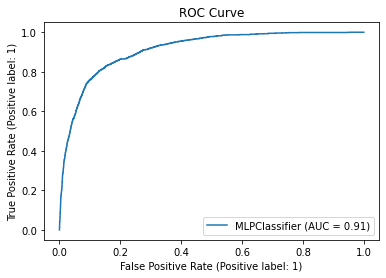

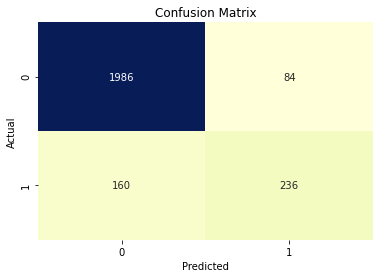

In [154]:
X_train, X_test, y_train, y_test = train_test_split(np.array(clust_pca), np.array(y1), test_size=0.20)
pca_est = MLPClassifier(hidden_layer_sizes=(5,), solver='adam', activation='logistic', learning_rate_init=0.01, random_state=2, max_iter=800)
train_sizes_pca, train_mean_pca, fit_mean_pca, pred_mean_pca = plot_learning_curve(pca_est, X_train, y_train, "NN Shoppers PCA_Clusters")
train_time_pca, pred_time_pca, f1_pca, accuracy_pca = final_classifier_evaluation(pca_est, X_train, X_test, y_train, y_test, "NN Shoppers PCA_Clusters")

C:\Users\jzhang\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (800) reached and the optimization hasn't converged yet.
  warnings.warn(


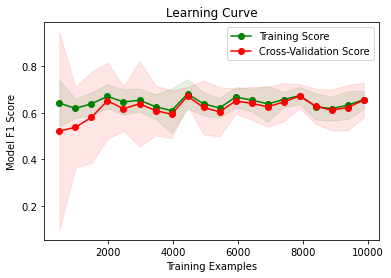

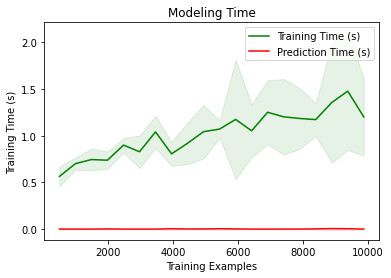

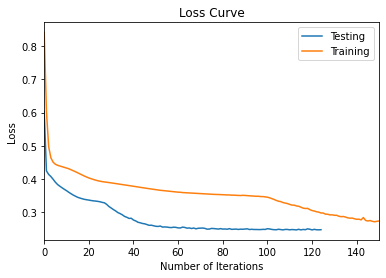

Model Training Time (s):   1.61381
Model Prediction Time (s): 0.00045

F1 Score:  0.69
Accuracy:  0.90


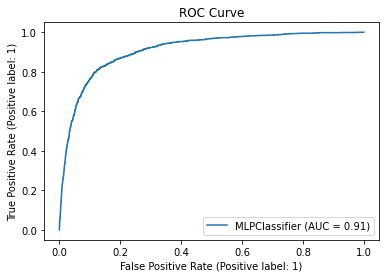

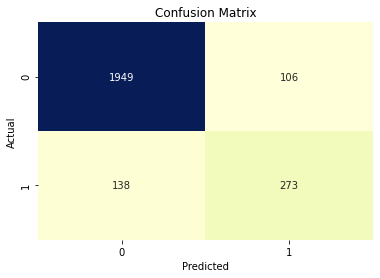

In [155]:
X_train, X_test, y_train, y_test = train_test_split(np.array(clust_ica), np.array(y1), test_size=0.20)
ica_est = MLPClassifier(hidden_layer_sizes=(5,), solver='adam', activation='logistic', learning_rate_init=0.01, random_state=2, max_iter=800)
train_sizes_ica, train_mean_ica, fit_mean_ica, pred_mean_ica = plot_learning_curve(ica_est, X_train, y_train, "NN Shoppers ICA_Clusters")
train_time_ica, pred_time_ica, f1_ica, accuracy_ica = final_classifier_evaluation(ica_est, X_train, X_test, y_train, y_test, "NN Shoppers ICA_Clusters")

C:\Users\jzhang\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (800) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jzhang\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (800) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jzhang\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (800) reached and the optimization hasn't converged yet.
  warnings.warn(


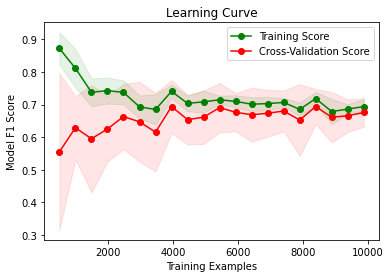

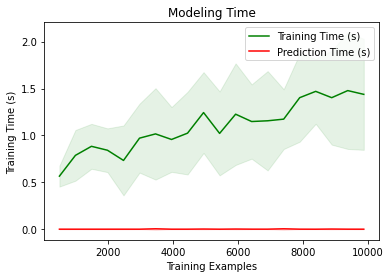

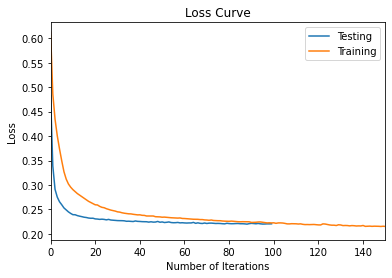

Model Training Time (s):   1.34000
Model Prediction Time (s): 0.00050

F1 Score:  0.65
Accuracy:  0.90


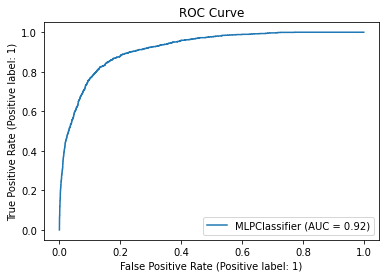

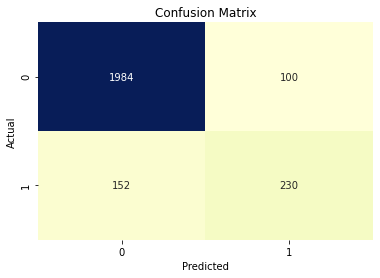

In [156]:
X_train, X_test, y_train, y_test = train_test_split(np.array(clust_rca), np.array(y1), test_size=0.20)
rca_est = MLPClassifier(hidden_layer_sizes=(5,), solver='adam', activation='logistic', learning_rate_init=0.01, random_state=2, max_iter=800)
train_sizes_rca, train_mean_rca, fit_mean_rca, pred_mean_rca = plot_learning_curve(rca_est, X_train, y_train, "NN Shoppers RCA_Clusters")
train_time_rca, pred_time_rca, f1_rca, accuracy_rca = final_classifier_evaluation(rca_est, X_train, X_test, y_train, y_test, "NN Shoppers RCA_Clusters")

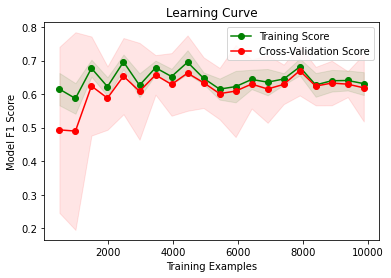

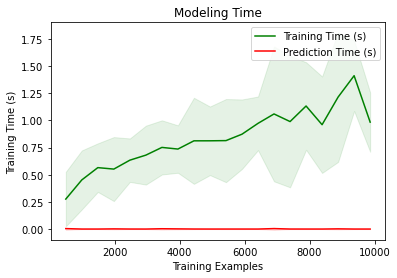

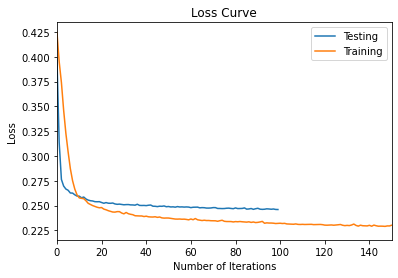

Model Training Time (s):   1.26861
Model Prediction Time (s): 0.00044

F1 Score:  0.63
Accuracy:  0.90


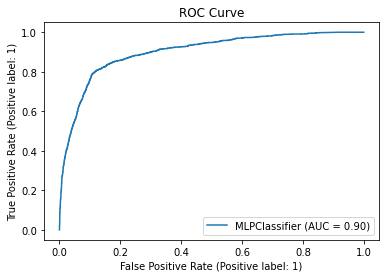

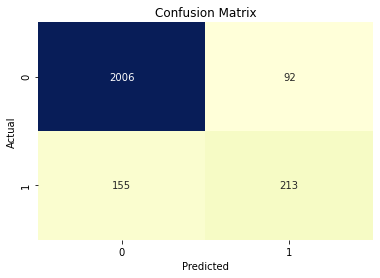

In [157]:
X_train, X_test, y_train, y_test = train_test_split(np.array(clust_rfc), np.array(y1), test_size=0.20)
rf_est = MLPClassifier(hidden_layer_sizes=(5,), solver='adam', activation='logistic', learning_rate_init=0.01, random_state=2, max_iter=800)
train_sizes_rf, train_mean_rf, fit_mean_rf, pred_mean_rf = plot_learning_curve(rf_est, X_train, y_train, "NN Shoppers RF_Clusters")
train_time_rf, pred_time_rf, f1_rf, accuracy_rf = final_classifier_evaluation(rf_est, X_train, X_test, y_train, y_test, "NN Shoppers RF_Clusters")

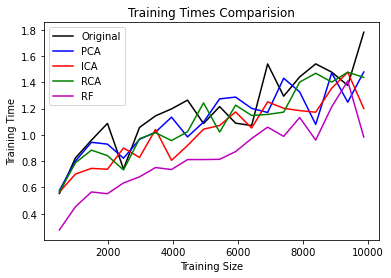

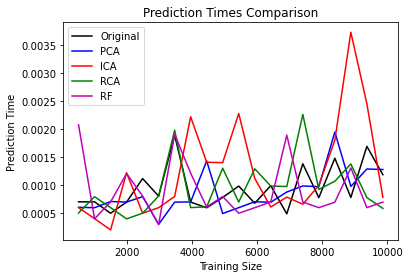

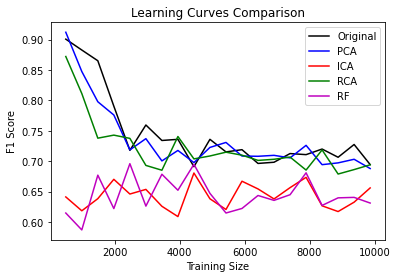

In [158]:
compare_plots(train_sizes, 
    train_mean, train_mean_pca,train_mean_ica,train_mean_rca,train_mean_rf,
    fit_mean, fit_mean_pca,fit_mean_ica,fit_mean_rca,fit_mean_rf,
    pred_mean,pred_mean_pca,pred_mean_ica,pred_mean_rca,pred_mean_rf
    ,'NN_Shoppers_Clusters') 

In [159]:
df1 = pd.DataFrame(zip(["Original","PCA","ICA","RCA","RF"],[f1,f1_pca,f1_ica,f1_rca,f1_rf]),columns = ['Model','f1'])
df2 = pd.DataFrame(zip(["Original","PCA","ICA","RCA","RF"],[accuracy, accuracy_pca, accuracy_ica, accuracy_rca, accuracy_rf]),columns = ['Model','acc'])
df3 = pd.DataFrame(zip(["Original","PCA","ICA","RCA","RF"],[train_time, train_time_pca, train_time_ica, train_time_rca, train_time_rf]),columns = ['Model','time_train'])
df4 = pd.DataFrame(zip(["Original","PCA","ICA","RCA","RF"],[pred_time, pred_time_pca, pred_time_ica, pred_time_rca, pred_time_rf]),columns = ['Model','time_test'])

models = pd.merge(pd.merge(pd.merge(df1,df2,on='Model'),df3,on='Model'),df4,on='Model')
models

,Model,f1,acc,time_train,time_test
0,Original,0.660140,0.901460,1.706508,0.000514
1,PCA,0.659218,0.901054,1.487456,0.000474
2,ICA,0.691139,0.901054,1.613811,0.000453
3,RCA,0.646067,0.897810,1.339997,0.000499
4,RF,0.632987,0.899838,1.268609,0.000444


<Figure size 576x576 with 0 Axes>

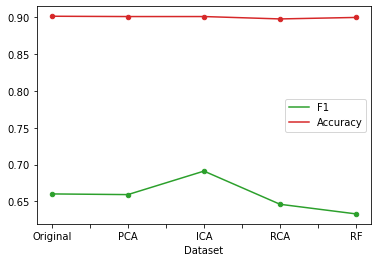

<Figure size 576x576 with 0 Axes>

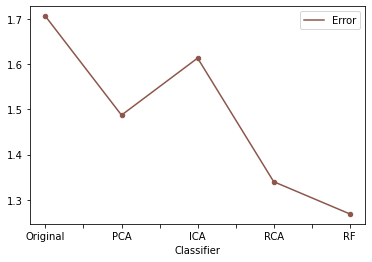

In [160]:
fig = plt.figure(figsize=(8,8))
fig.suptitle('Comparision - Scores')
ax = models.plot(x ="Model", y="f1", kind = "line", label = "F1", color="C2")
models.plot(x ="Model", y="f1", kind = "scatter", ax = ax, color="C2")
models.plot(x ="Model", y="acc", ax = ax, kind = "line", label = "Accuracy",color="C3")
models.plot(x ="Model", y="acc", ax = ax, kind = "scatter", color="C3")

plt.xlabel('Dataset')
plt.ylabel("")
plt.legend(loc="best")
plt.savefig('./Compare_f1_shoppers_Clusters.png')
plt.show()


fig = plt.figure(figsize=(8,8))
fig.suptitle('Comparision - Time')
ax = models.plot(x ="Model", y="time_train", kind = "line", label = "Error",color="C5")
models.plot(x ="Model", y="time_train", ax = ax,kind = "scatter", color="C5")
plt.xlabel('Classifier')
plt.ylabel("")
plt.legend(loc="best")
plt.savefig('./Compare_time_shoppers_Clusters.png')
plt.show()